In [1]:

def read_dataset(filename):
    filepath = "/home/faiak/Desktop/Academic/Data-Mining/Assignemnt_3/Datasets/" + filename
    with open(filepath, 'r') as file:
        # Read the file and split each transaction by spaces
        transactions = [[int(item) for item in line.strip().split()] for line in file.readlines()]
    return transactions


## APIRORI



from collections import defaultdict

def find_frequent_1_itemsets(transactions, min_sup):
    item_count = defaultdict(int)
    for transaction in transactions:
        for item in set(transaction):  # Ensure that we count unique items
            item_count[item] += 1
    
    L1 = set()
    for item, count in item_count.items():
        if count >= min_sup:
            L1.add(tuple([item]))  # Create a frozenset of the frequent items
    

    return sorted(list(L1), key=lambda x: sorted(x))


import copy


def has_infrequent_subset(candidate, prev_frequent_itemsets):
    # print(f"candidate : {candidate}")
    # print(f"prev_freq_itemsets: {prev_frequent_itemsets}")
    for item in candidate:
        subset = copy.deepcopy(candidate)
        subset.remove(item)
        # if subset not in prev_frequent_itemsets:
        #     return True  # If any subset is not frequent, return True

        if not any(set(subset).issubset(set(sublist)) for sublist in prev_frequent_itemsets):
            return True
        
    return False  # Otherwise, return False


def apriori_gen(Lk_minus_1 : list[list[str]], k_1:int):
    candidates = []
    Lk_minus_1 = sorted(Lk_minus_1)
    # Lk_minus_1 = [sorted(row) for row in Lk_minus_1]

    # print(f"Lk_minus_1: {Lk_minus_1}")

    for i in range(len(Lk_minus_1)):
        for j in range(i + 1, len(Lk_minus_1)):
            l1 = list(Lk_minus_1[i])
            l2 = list(Lk_minus_1[j])

            # print(f"l1: {l1}, l2: {l2}")

            if l1[:k_1-1] == l2[:k_1-1] and l1[k_1-1] < l2[k_1-1]:
                candidate = sorted(l1[:k_1-1] + [l1[k_1-1]] + [l2[k_1-1]])

                # print(f"Candidate: {candidate}")

                if not has_infrequent_subset(candidate, Lk_minus_1):
                    candidates.append(candidate)
    return candidates

def count_support(transactions, itemset):
    count = 0
    itemset = set(itemset)
    for transaction in transactions:
        transaction_set = set(transaction)
        if itemset.issubset(transaction_set):
            count += 1
    return count

def APRIORI_ALGO(Transactions, min_sup):
    L = []

    L1 = find_frequent_1_itemsets(Transactions, min_sup)

    total_patterns = 0

    # print(L1)

    # print("Frequent 1-itemsets:")
    # for itemset in L1:
    #     print(itemset)
    # The output will show the frequent 1-itemsets found in the dataset

    L.append(L1)
    Lk_minus_1 = L1

    total_patterns += len(L1)

    k = 2

    # Ck = apriori_gen(Lk_minus_1, k - 1)
    # print(f"Candidates for {k}-itemsets: {Ck}")
    while Lk_minus_1:
        # print(f"k : {k}")
        Ck = apriori_gen(Lk_minus_1, k - 1)

        # print(f"len(Ck) : {len(Ck)}")
        # print(f"Candidates for {k}-itemsets: {Ck}")
        Lk = []
        for candidate in Ck:
            if count_support(Transactions, candidate) >= min_sup:
                Lk.append(list(sorted(candidate)))
        if not Lk:
            break
        L.append(Lk)

        # print(f"len(Lk) : {len(Lk)}")
        total_patterns += len(Lk)

        Lk_minus_1 = Lk
        
        # print(f"#####  Frequent {k}-itemsets: {Lk}")

        k += 1

    # print(f"L : {L}")
    print(f"length of frequent itemsets in APRIORI : {total_patterns}")

    return total_patterns



### FP_GROWTH


from collections import defaultdict

class Node:
    def __init__(self, item, count, parent):
        self.item = item
        self.count = count
        self.parent = parent
        self.children = {}
        self.link_next= None


    def display(self, ind=1):
        print('  ' * ind, f'{self.item}: {self.count}')
        for child in self.children.values():
            child.display(ind + 1)


def BUILD_TREE(transactions, min_support):
    header_table = defaultdict(int)
    for transaction in transactions:
        for item in transaction:
            header_table[item] += 1
    header_table = {k: v for k, v in header_table.items() if v >= min_support}
    if not header_table:
        return None, None
    for key in header_table:
        header_table[key] = [header_table[key], None]
    root = Node(None, 1, None)
    for transaction in transactions:
        filtered_transaction = [item for item in transaction if item in header_table]
        filtered_transaction.sort(key=lambda x: header_table[x][0], reverse=True)
        insert_tree(filtered_transaction, root, header_table)
    return root, header_table

def insert_tree(items, node, header_table):
    if items:
        first_item = items[0]
        if first_item in node.children:
            node.children[first_item].count += 1
        else:
            new_node = Node(first_item, 1, node)
            node.children[first_item] = new_node
            if header_table[first_item][1] is None:
                header_table[first_item][1] = new_node
            else:
                current = header_table[first_item][1]
                while current.link_next is not None:
                    current = current.link_next
                current.link_next= new_node
        insert_tree(items[1:], node.children[first_item], header_table)


def MINE_TREE(header_table, min_support, prefix, frequent_itemsets):
    sorted_items = sorted(header_table.items(), key=lambda x: x[1][0])
    for base_item, (count, node) in sorted_items:
        new_prefix = prefix.copy()
        new_prefix.add(base_item)
        frequent_itemsets.append((new_prefix, count))
        conditional_pattern_base = []
        while node is not None:
            path = []
            parent = node.parent
            while parent is not None and parent.item is not None:
                path.append(parent.item)
                parent = parent.parent
            path.reverse()
            for _ in range(node.count):
                conditional_pattern_base.append(path)
            node = node.link_next
        conditional_tree, conditional_header = BUILD_TREE(conditional_pattern_base, min_support)
        if conditional_header is not None:
            # print(f"\nConditional FP-tree for prefix {new_prefix}:")
            # conditional_tree.display()
            MINE_TREE(conditional_header, min_support, new_prefix, frequent_itemsets)

def FP_TREE_ALGO(Transactions, min_sup):
    root, header_table = BUILD_TREE(Transactions, min_sup)
    frequent_itemsets = []
    if root is not None:
        MINE_TREE(header_table, min_sup, set(), frequent_itemsets)

    print(f"length of frequent itemsets in FP_GROWTH : {len(frequent_itemsets)}")
    return len(frequent_itemsets)
    # print(frequent_itemsets)





In [2]:
import re
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

def plot_graphs(filename, min_sup, apriori_time, fp_growth_time, apriori_memory, fp_growth_memory):
    # Line plot for execution time
    plt.figure(figsize=(8, 5))
    plt.plot(min_sup, apriori_time, marker='o', label='Apriori')
    plt.plot(min_sup, fp_growth_time, marker='s', label='FP-Growth')

    for i, v in enumerate(apriori_time):
        plt.text(min_sup[i], v + max(apriori_time)*0.02, f"{v:.2f}", ha='center', va='bottom', fontsize=8)
    for i, v in enumerate(fp_growth_time):
        plt.text(min_sup[i], v + max(fp_growth_time)*0.02, f"{v:.2f}", ha='center', va='bottom', fontsize=8)

    plt.title('Execution Time vs Min Support')
    plt.xlabel('Min Support (%)')
    plt.ylabel('Execution Time (seconds)')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(f"{filename}_execution_time.png")
    plt.show()

    # Bar plot for memory usage
    x = np.arange(len(min_sup))
    width = 0.35

    fig, ax = plt.subplots(figsize=(8, 5))
    bars1 = ax.bar(x - width/2, apriori_memory, width, label='Apriori')
    bars2 = ax.bar(x + width/2, fp_growth_memory, width, label='FP-Growth')

    for bar in bars1:
        yval = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2, yval + 0.02, f"{yval:.2f}", ha='center', va='bottom', fontsize=8)
    for bar in bars2:
        yval = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2, yval + 0.02, f"{yval:.2f}", ha='center', va='bottom', fontsize=8)

    ax.set_xlabel('Min Support (%)')
    ax.set_ylabel('Memory Usage (MB)')
    ax.set_title('Memory Usage Comparison')
    ax.set_xticks(x)
    ax.set_xticklabels(min_sup)
    ax.legend()
    plt.grid(True, axis='y')
    plt.tight_layout()
    plt.savefig(f"{filename}_memory_usage.png")
    plt.show()

# ---- Step 4: Generate Clean Table ----
def generate_clean_table(filename, min_sup, apriori_time, fp_growth_time, apriori_memory, fp_growth_memory, apriori_freq, fp_growth_freq):
    # Create lists for table structure
    rows = []
    
    # For each min_sup value
    for i, sup in enumerate(min_sup):
        # First row in group - contains min_sup
        rows.append([f"{sup}%", 'Runtime (s)', f"{apriori_time[i]:.2f}", f"{fp_growth_time[i]:.2f}"])
        # Second and third rows - empty min_sup cell
        rows.append(['', 'Memory (MB)', f"{apriori_memory[i]:.2f}", f"{fp_growth_memory[i]:.2f}"])
        rows.append(['', 'Frequent Items', f"{apriori_freq[i]}", f"{fp_growth_freq[i]}"])

    table_df = pd.DataFrame(rows, columns=['Min_sup', 'Metric', 'Apriori', 'FP-Growth'])

    # Print clean table
    print("\n📋 Comparison Table:\n")
    print(table_df.to_string(index=False))

    # Plotting the table
    fig, ax = plt.subplots(figsize=(10, len(rows)*0.4 + 1))
    ax.axis('off')
    
    # Define colors
    header_color = '#4472C4'  # Blue for header
    alt_color = '#E6F0FF'     # Light blue for alternating groups
    
    # Create cell colors for alternating groups
    cell_colors = []
    for i in range(len(rows)):
        group = i // 3  # Determine which min_sup group this row belongs to
        if group % 2 == 0:  # Alternating groups
            cell_colors.append(['white', 'white', 'white', 'white'])
        else:
            cell_colors.append([alt_color, alt_color, alt_color, alt_color])
    
    # Create table
    table = ax.table(
        cellText=table_df.values,
        colLabels=table_df.columns,
        cellLoc='center',
        loc='center',
        cellColours=cell_colors
    )
    
    # Style the header
    for i in range(len(table_df.columns)):
        table[(0, i)].set_facecolor(header_color)
        table[(0, i)].set_text_props(color='white', fontweight='bold')
    
    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.scale(1, 1.2)  # Make rows a bit taller
    
    # Set column widths
    table.auto_set_column_width(col=list(range(len(table_df.columns))))

    # Add border lines
    for key, cell in table._cells.items():
        cell.set_edgecolor('lightgray')

    # Set title
    plt.suptitle(f'Performance Comparison: Apriori vs FP-Growth', fontsize=14, y=0.98)
    plt.title(f'Dataset: {filename}', fontsize=12)

    plt.tight_layout()
    plt.savefig(f"{filename}_clean_table.png", bbox_inches='tight', dpi=300)
    plt.show()

    print(f"\n✅ Clean table saved as: {filename}_clean_table.png")

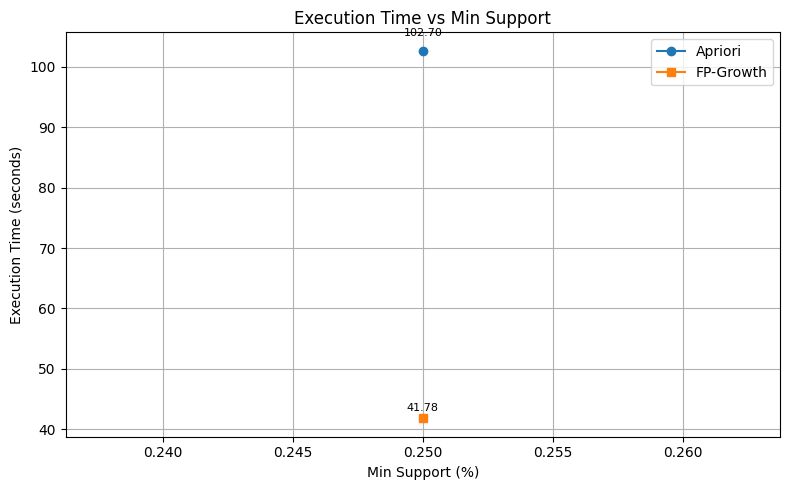

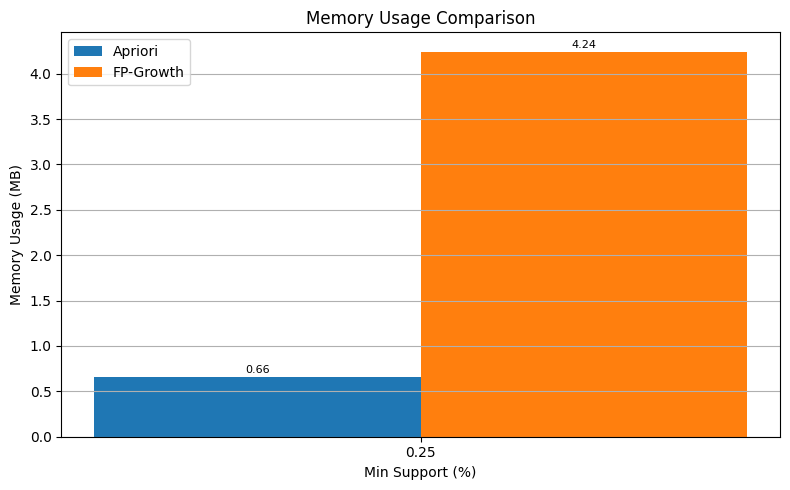

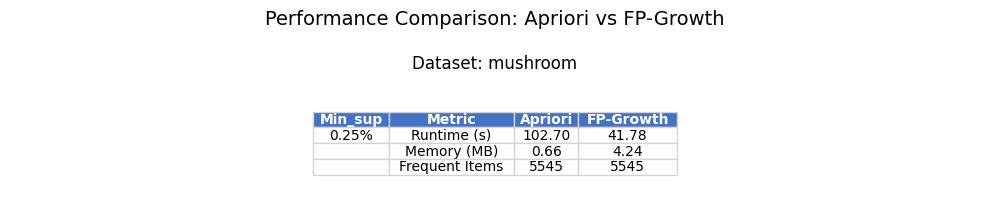

In [3]:
import time
import tracemalloc
import math
import sys, os ,gc

def measure_time_memory(func, *args, **kwargs):
    tracemalloc.start()
    start_time = time.time()

    result = func(*args, **kwargs)

    end_time = time.time()
    current, peak = tracemalloc.get_traced_memory()
    tracemalloc.stop()

    time_taken = end_time - start_time
    memory_mb = peak / (1024 * 1024)

    return time_taken, memory_mb, result

if __name__ == "__main__":
    os.makedirs('./Output', exist_ok=True)
    output_file = './Output/output.txt'
    sys.stdout = open(output_file, 'w')

    filename = 'mushroom'
    filepath = f'{filename}.txt'
    Transactions = read_dataset(filepath)

    min_sup_values = [0.25]

    apriori_times, fp_growth_times = [], []
    apriori_mems, fp_growth_mems = [], []
    apriori_freqs, fp_growth_freqs = [], []

    for min_sup in min_sup_values:
        print(f"\n===== Min Support: {min_sup} =====\n")

        min_sup = min_sup * len(Transactions)

        a_time, a_mem, a_freq = measure_time_memory(APRIORI_ALGO, Transactions=Transactions, min_sup=min_sup)
        f_time, f_mem, f_freq = measure_time_memory(FP_TREE_ALGO, Transactions=Transactions, min_sup=min_sup)

        apriori_times.append(a_time)
        fp_growth_times.append(f_time)
        apriori_mems.append(a_mem)
        fp_growth_mems.append(f_mem)
        apriori_freqs.append(a_freq)
        fp_growth_freqs.append(f_freq)

    # Plotting and table generation
    plot_graphs(filename, min_sup_values, apriori_times, fp_growth_times, apriori_mems, fp_growth_mems)
    generate_clean_table(filename, min_sup_values, apriori_times, fp_growth_times, apriori_mems, fp_growth_mems, apriori_freqs, fp_growth_freqs)

    print("\n✅ All outputs saved.")

    gc.collect()


import pyttsx3

# Initialize the TTS engine
engine = pyttsx3.init()

# Set the text you want to speak
text = "finish finish finish"

# Speak the text
engine.say(text)

# Wait for the speech to finish
engine.runAndWait()
# Or any .wav/.mp3 you have
